# Sentiment analysis

Анализ тональности твитов первых президентский дебатов (2016 GOP Presidential Debate)

Данильченко Вадим

In [1]:
import numpy as np 
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Dense, Input, Embedding, LSTM, SpatialDropout1D
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
import matplotlib.pyplot as plt

Using TensorFlow backend.


Only keeping the necessary columns.

In [2]:
# загрузим данные
data = pd.read_csv('../data/first-gop-debate-twitter-sentiment/Sentiment.csv')
data = data[['text','sentiment']]
data.head()

,text,sentiment
0,RT @NancyLeeGrahn: How did everyone feel about...,Neutral
1,RT @ScottWalker: Didn't catch the full #GOPdeb...,Positive
2,RT @TJMShow: No mention of Tamir Rice and the ...,Neutral
3,RT @RobGeorge: That Carly Fiorina is trending ...,Positive
4,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,Positive


In [3]:
# предобработаем текст
data = data[data.sentiment != "Neutral"]

def preprocessing(phrase):
    phrase = str(phrase).lower().replace('\n',' ').replace('rt',' ')
    phrase = re.sub('[^a-zA-z0-9\ ]', ' ', phrase)
    phrase = re.sub('\ {2,}', ' ', phrase)
    return phrase.strip()
    
data['text'] = data['text'].apply(lambda x: (preprocessing(x) if len(x)>0 else None))
data['text'].dropna()

print('количество элементов в классах: ', dict(Counter(data['sentiment'])))

количество элементов в классах:  {'Positive': 2236, 'Negative': 8493}


In [4]:
# представим каждый текст из X как последовательность индексов слов
tokenizer = Tokenizer(split=' ')
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X)
X[:2]

array([[   0,    0,    0,    0,    0,    0,    0,  344,  131,    4, 2405,
           1,  708,    2,   45,   44,  196,   42,  217,    8,  304,   12,
         180, 1749,   17, 1319, 1408,  727,   14,    4,   11, 6243],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0, 6244,   20,
         291,  250,    6, 4239,  828,  107,  173,   30, 2776,  143,    8,
           1,  169,   17,   40, 6245,    2,  239,  155,   12,   22]])

In [5]:
# сделаем аугметацию 
ros = RandomOverSampler(random_state=777)
X, y = ros.fit_sample(X, data['sentiment'])

print('количество элементов в классах после аугментации: ', dict(Counter(y)))

количество элементов в классах после аугментации:  {'Positive': 8493, 'Negative': 8493}


In [6]:
# преобразуем Y в формат [0, 1], где 1 будет на пересечении с целевым классом для каждого элемента
Y = pd.get_dummies(y).values
Y.shape

(16986, 2)

In [7]:
# разделим на тренировочную и валидационную выборки
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size = 0.3, random_state = 777)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(11890, 32) (11890, 2)
(5096, 32) (5096, 2)


построим модель

In [8]:
# задаем гиперпараметры
MAX_VOCAB_SIZE = len(tokenizer.word_index)+1
EMBEDDING_DIM = 128
MAX_SEQ_LEN = X.shape[1]
BATCH_SIZE = 64
EPOCHS = 6
CLASSES = 2

In [9]:
# скомпилируем модель

embedding_layer = Embedding(MAX_VOCAB_SIZE,
                            EMBEDDING_DIM,
                            input_length=MAX_SEQ_LEN,
                            trainable=True
                            )

input_ = Input(shape=(MAX_SEQ_LEN, ), name='input')
emb = embedding_layer(input_)

x = SpatialDropout1D(0.4)(emb)
x = LSTM(EMBEDDING_DIM, recurrent_dropout=0.2, name='LSTM')(x)
output = Dense(CLASSES, activation='softmax', name='Dense')(x)

model = Model(input_, output)
model.compile(metrics=['accuracy'],
                optimizer=Adam(learning_rate=0.001),
                loss='categorical_crossentropy')
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 32)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 32, 128)           1914496   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 32, 128)           0         
_________________________________________________________________
LSTM (LSTM)                  (None, 128)               131584    
_________________________________________________________________
Dense (Dense)                (None, 2)                 258       
Total params: 2,046,338
Trainable params: 2,046,338
Non-trainable params: 0
_________________________________________________________________


In [10]:
# обучим
r = model.fit(x_train, 
          y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test),
          verbose=1)

C:\Users\vndan\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 11890 samples, validate on 5096 samples
Epoch 1/6
11890/11890 [==============================] - 16s 1ms/step - loss: 0.4660 - accuracy: 0.7664 - val_loss: 0.3259 - val_accuracy: 0.8717
Epoch 2/6
11890/11890 [==============================] - 15s 1ms/step - loss: 0.2395 - accuracy: 0.9074 - val_loss: 0.2517 - val_accuracy: 0.9056
Epoch 3/6
11890/11890 [==============================] - 16s 1ms/step - loss: 0.1521 - accuracy: 0.9447 - val_loss: 0.2321 - val_accuracy: 0.9088
Epoch 4/6
11890/11890 [==============================] - 16s 1ms/step - loss: 0.1157 - accuracy: 0.9588 - val_loss: 0.1989 - val_accuracy: 0.9321
Epoch 5/6
11890/11890 [==============================] - 16s 1ms/step - loss: 0.0918 - accuracy: 0.9662 - val_loss: 0.2124 - val_accuracy: 0.9270
Epoch 6/6
11890/11890 [==============================] - 15s 1ms/step - loss: 0.0843 - accuracy: 0.9667 - val_loss: 0.2088 - val_accuracy: 0.9233


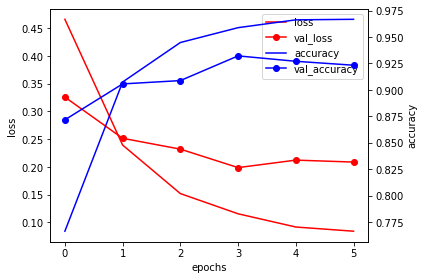

In [11]:
# посмотрим на историю обучения

fig, ax1 = plt.subplots()

t = np.arange(0, len(r.history['accuracy']), 1)

ln1 = ax1.plot(t, r.history['loss'], color='r', label='loss')
ln2 = ax1.plot(t, r.history['val_loss'], color='r', marker='o', label='val_loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
# ax1.legend(loc=0)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis


ln3 = ax2.plot(t, r.history['accuracy'], color='b', label='accuracy')
ln4 = ax2.plot(t, r.history['val_accuracy'], color='b', marker='o', label='val_accuracy')
ax2.set_ylabel('accuracy')  # we already handled the x-label with ax1
# ax2.legend(loc=0)

lns = ln1+ln2+ln3+ln4
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.legend(loc='lower right')
plt.show()

посморим на метрики

In [12]:
validation_size = 1500

X_validate = x_test[-validation_size:]
Y_validate = y_test[-validation_size:]
X_test = x_test[:-validation_size]
Y_test = y_test[:-validation_size]
score,acc = model.evaluate(x_test, y_test, verbose = 2, batch_size = BATCH_SIZE)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

score: 0.21
acc: 0.92


In [13]:
from sklearn.metrics import classification_report
print(classification_report(y_test, np.round(model.predict(x_test))))

              precision    recall  f1-score   support

           0       0.96      0.89      0.92      2574
           1       0.89      0.96      0.93      2522

   micro avg       0.92      0.92      0.92      5096
   macro avg       0.93      0.92      0.92      5096
weighted avg       0.93      0.92      0.92      5096
 samples avg       0.92      0.92      0.92      5096



поиграем с парочкой примеров

In [14]:
new_text = 'they are our future shure i will vote'
['negative', 'positive'][np.argmax(model.predict(pad_sequences(tokenizer.texts_to_sequences([new_text]), maxlen=len(X[0])))[0])]

'positive'

In [15]:
new_text = 'they are stupid I will not vote'
['negative', 'positive'][np.argmax(model.predict(pad_sequences(tokenizer.texts_to_sequences([new_text]), maxlen=len(X[0])))[0])]

'negative'